In [1]:
from isaacgym import rlgpu
from rlgpu.utils.config import set_np_formatting, set_seed
# leibniz-gym: dump all environments for loading
from leibnizgym.envs.trifinger import TrifingerEnv as Trifinger
# leibnizgym
from leibnizgym.wrappers.vec_task import VecTaskPython
from leibnizgym.utils.config_utils import load_cfg, get_args
from leibnizgym.utils.errors import InvalidTaskNameError
from leibnizgym.utils.message import *
# rl-games
from rl_games.common import env_configurations, vecenv
from rl_games.torch_runner import Runner
from rl_games.common import wrappers
from rl_games.common.algo_observer import AlgoObserver
from rl_games.algos_torch import torch_ext
import torch
import numpy as np
# python
import os
import argparse
import yaml
from datetime import datetime
from rl_games.torch_runner import Runner
import yaml
from leibnizgym.utils.config_utils import get_custom_parameters
from argparse import ArgumentParser


def parse_vec_task(args: argparse.Namespace, cfg: dict) -> VecTaskPython:
    """Parses the configuration parameters for the environment task.

    TODO (@mayank): Remove requirement for args and make this a normal function
                    inside utils.
    Args:
        args: command line arguments.
        cfg: environment configuration dictionary (task)

    Returns:
        TThe vectorized RL-env wrapped around the task.
    """
    # create native task and pass custom config
    if args.task_type == "Python":
        # check device on which to run agent and environment
        if args.device == "CPU":
            print("Running using python CPU...")
            # check if agent is on different device
            sim_device = 'cpu'
            ppo_device = 'cuda:0' if args.ppo_device == "GPU" else 'cpu'
        else:
            print("Running using python GPU...")
            sim_device = 'cuda:0'
            ppo_device = 'cuda:0'
        # create the IsaacEnvBase defined using leibnizgym
        try:
            task = eval(args.task)(config=cfg, device=sim_device,
                                   visualize=not args.headless,
                                   verbose=args.verbose)
        except NameError:
            raise InvalidTaskNameError(args.task)
        # wrap environment around vec-python wrapper
        env = VecTaskPython(task, rl_device=ppo_device, clip_obs=5, clip_actions=1)
    else:
        raise ValueError(f"No task of type `{args.task_type}` in leibnizgym.")

    return env


def create_rlgpu_env(**kwargs):
    """
    Creates the task from configurations and wraps it using RL-games wrappers if required.
    """
    # TODO (@arthur): leibnizgym parse task
    env = parse_vec_task(parsed_args, task_cfg)
    # print the environment information
    print(env)
    # save environment config into file
    env.dump_config(os.path.join(logdir, 'env_config.yaml'))
    # wrap around the environment
    frames = kwargs.pop('frames', 1)
    if frames > 1:
        env = wrappers.FrameStack(env, frames, False)
    return env


class RlGamesGpuEnvAdapter(vecenv.IVecEnv):
    """
    Adapter from VecPythonTask to Rl-Games VecEnv.
    """

    def __init__(self, config_name: str, num_actors: int, **kwargs):
        # this basically calls the `create_rlgpu_env()` function for RLGPU environment.
        self.env = env_configurations.configurations[config_name]['env_creator'](**kwargs)
        # check if environment is for asymmetric PPO or not
        self.use_global_obs = (self.env.num_states > 0)
        # get initial observations
        self.full_state = {
            "obs": self.env.reset()
        }
        # get state if assymmetric environment
        if self.use_global_obs:
            self.full_state["states"] = self.env.get_state()

    """
    Properties
    """

    def get_number_of_agents(self):
        return self.env.get_number_of_agents()

    def get_env_info(self):
        info = {
            'num_envs': self.env.num_envs,
            'action_space': self.env.action_space,
            'observation_space': self.env.observation_space
        }
        # print the spaces (for debugging)
        print(">> Action space: ", info['action_space'])
        print(">> Observation space: ", info['observation_space'])
        # check if environment is for asymmetric PPO or not
        if self.use_global_obs:
            info['state_space'] = self.env.state_space
            print(">> State space: ", info['state_space'])
        # return the information about spaces
        return info

    """
    Operations
    """

    def reset(self):
        # reset the environment
        self.full_state["obs"] = self.env.reset()
        # check if environment is for asymmetric PPO or not
        if self.use_global_obs:
            self.full_state["states"] = self.env.get_state()
            return self.full_state
        else:
            return self.full_state["obs"]

    def step(self, action):
        # step through the environment
        next_obs, reward, is_done, info = self.env.step(action)
        # check if environment is for asymmetric PPO or not
        # TODO (@arthur): Improve the return only dictinary
        self.full_state["obs"] = next_obs
        if self.use_global_obs:
            self.full_state["states"] = self.env.get_state()
            return self.full_state, reward, is_done, [[], info]
        else:
            return self.full_state["obs"], reward, is_done, [[], info]


# register the rl-games adapter to use inside the runner
vecenv.register('RLGPU', lambda config_name, num_actors, **kwargs: RlGamesGpuEnvAdapter(config_name, num_actors, **kwargs))
env_configurations.register('rlgpu', {
    'vecenv_type': 'RLGPU',
    'env_creator': lambda **kwargs: create_rlgpu_env(**kwargs),
})


class LeibnizAlgoObserver(AlgoObserver):
    """Allows us to log stats from the env along with the algorithm running stats. """

    def __init__(self):
        pass

    def after_init(self, algo):
        self.algo = algo
        self.game_scores = torch_ext.AverageMeter(1, self.algo.games_to_track).to(self.algo.ppo_device)
        self.direct_info = {}
        self.writer = self.algo.writer

    def process_infos(self, infos, done_indices):
        if not infos:
            return
        if len(infos) > 0 and isinstance(infos[0], dict):
            for ind in done_indices:
                if len(infos) <= ind // self.algo.num_agents:
                    continue
                info = infos[ind // self.algo.num_agents]
                game_res = None
                if 'battle_won' in info:
                    game_res = info['battle_won']
                if 'scores' in info:
                    game_res = info['scores']

                if game_res is not None:
                    self.game_scores.update(torch.from_numpy(np.asarray([game_res])).to(self.algo.ppo_device))
        if len(infos) > 1 and isinstance(infos[1], dict):  # allow direct logging from env
            self.direct_info = infos[1]

    def after_clear_stats(self):
        self.game_scores.clear()

    def after_print_stats(self, frame, epoch_num, total_time):
        if self.game_scores.current_size > 0:
            mean_scores = self.game_scores.get_mean()
            self.writer.add_scalar('scores/mean', mean_scores, frame)
            self.writer.add_scalar('scores/iter', mean_scores, epoch_num)
            self.writer.add_scalar('scores/time', mean_scores, total_time)
        for k, v in self.direct_info.items():
            self.writer.add_scalar(k, v, frame)

Importing module 'gym_38' (/scr-ssd/ksrini/Downloads/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /scr-ssd/ksrini/Downloads/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
Importing module 'rlgpu_38' (/scr-ssd/ksrini/Downloads/isaacgym/python/isaacgym/_bindings/linux-x86_64/rlgpu_38.so)
PyTorch version 1.9.1+cu102
Device count 1
/scr-ssd/ksrini/Downloads/isaacgym/python/isaacgym/_bindings/src/gymtorch
Using /afs/cs.stanford.edu/u/ksrini/.cache/torch_extensions as PyTorch extensions root...
Emitting ninja build file /afs/cs.stanford.edu/u/ksrini/.cache/torch_extensions/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module gymtorch...
WARNING - pyDR not installed. Domain Randomization functionality will not be available.


In [3]:
ft_forces = np.array([[0.0011575117241591215,
  0.21578621864318848,
  -0.21428455412387848,
  -2.7175790506817066e-09,
  1.1599340932200164e-10,
  1.1680727218799092e-10,
  0.0025175963528454304,
  0.21157078444957733,
  -0.2184360921382904],
 [-0.00163232849445194,
  0.21341754496097565,
  -0.2166406512260437,
  -4.24288337796952e-09,
  2.6515816209382592e-09,
  2.6121618201813135e-09,
  0.005958329886198044,
  0.19017811119556427,
  -0.23723337054252625],
 [-0.007625578437000513,
  0.20844320952892303,
  -0.22130565345287323,
  -8.008003149484466e-09,
  4.9210244768005396e-09,
  4.6352730542764675e-09,
  0.01169075071811676,
  0.16426312923431396,
  -0.2556634247303009],
 [-0.016004009172320366,
  0.1998891681432724,
  -0.2286287546157837,
  -1.286871320616001e-08,
  6.819692366377694e-09,
  5.962399463044221e-09,
  0.02427522838115692,
  0.1458863615989685,
  -0.26572680473327637],
 [-0.025619488209486008,
  0.18610884249210358,
  -0.23914434015750885,
  -1.9819283991751036e-08,
  7.590672979063129e-09,
  5.9075810909803295e-09,
  0.03909069299697876,
  0.12896762788295746,
  -0.27262094616889954],
 [-0.03435948118567467,
  0.16580553352832794,
  -0.2526080906391144,
  -2.5960440908079363e-08,
  7.3442438797144405e-09,
  4.8204618074976224e-09,
  0.05695582181215286,
  0.1119883805513382,
  -0.27694323658943176],
 [-0.04152068495750427,
  0.14098750054836273,
  -0.2662356495857239,
  -3.0315931098812143e-08,
  5.582976747575685e-09,
  2.956668687659203e-09,
  0.07878950983285904,
  0.09760168194770813,
  -0.27703607082366943],
 [-0.04626872390508652,
  0.11075194925069809,
  -0.2794209122657776,
  -3.533198267291482e-08,
  5.185761153825297e-09,
  2.0548509560569528e-09,
  0.09871228039264679,
  0.07671821117401123,
  -0.2772238850593567],
 [-0.050466496497392654,
  0.07965385168790817,
  -0.28912147879600525,
  -2.9407789980950838e-08,
  1.7078092273692391e-09,
  4.702117584187704e-10,
  2.712690830230713,
  2.455031156539917,
  0.35590142011642456],
 [-0.04847986251115799,
  0.07034002244472504,
  -0.2918644845485687,
  1.195308918511273e-08,
  -8.424140829355053e-10,
  -2.0304816161775818e-10,
  0.1507198065519333,
  2.2656409740448,
  -0.44540098309516907],
 [-0.04677759110927582,
  0.08484697341918945,
  -0.28826335072517395,
  1.7228325432938618e-08,
  -5.625805155062835e-09,
  -1.6558570070657197e-09,
  0.1427343487739563,
  0.08221385627985,
  -0.2556377053260803],
 [-0.03405924141407013,
  0.10062498599290848,
  -0.28495165705680847,
  1.224799905941154e-08,
  -1.1417962575421825e-08,
  -4.032044476076635e-09,
  0.15208910405635834,
  0.10888408124446869,
  -0.23978324234485626],
 [-0.02242898941040039,
  0.1070362776517868,
  -0.28376588225364685,
  9.351221130771137e-09,
  -1.3023076839147052e-08,
  -4.912204865092917e-09,
  0.1576550453901291,
  0.13564026355743408,
  -0.22187720239162445],
 [-0.0059496634639799595,
  0.11548867076635361,
  -0.28126466274261475,
  3.1960427637756084e-09,
  -1.4475515008882667e-08,
  -5.943680214670621e-09,
  0.16452725231647491,
  0.15527068078517914,
  -0.20323562622070312],
 [0.0071678790263831615,
  0.1035194844007492,
  -0.285858690738678,
  -1.7853553302416003e-08,
  -1.2950652106269445e-08,
  -4.690448474065079e-09,
  0.17015887796878815,
  0.16215607523918152,
  -0.1929617077112198],
 [0.021098194643855095,
  0.07564852386713028,
  -0.293794184923172,
  -3.224709033133877e-08,
  -1.3087617212192981e-08,
  -3.3702540758184796e-09,
  0.17566566169261932,
  0.15780217945575714,
  -0.1916321963071823],
 [1.6610454320907593,
  -5.656965255737305,
  0.5082426071166992,
  -0.0005906553124077618,
  -0.00010646996815921739,
  -1.4207428648660425e-05,
  0.17832502722740173,
  0.1489465832710266,
  -0.19620908796787262],
 [0.8303273320198059,
  -3.453927755355835,
  0.5622687339782715,
  -0.0003912492247764021,
  -5.110670826979913e-05,
  -4.392580194689799e-06,
  0.182470440864563,
  0.14447420835494995,
  -0.19574125111103058],
 [0.7542234659194946,
  -3.528127431869507,
  0.7239878177642822,
  -0.0004201327101327479,
  -4.4933640310773626e-05,
  -1.6284402590827085e-06,
  0.18211649358272552,
  0.14217664301395416,
  -0.19774281978607178],
 [0.821757435798645,
  -3.231844186782837,
  0.632408857345581,
  -0.0003889173676725477,
  -4.8003541451180354e-05,
  -1.8775160981476802e-07,
  0.1793125569820404,
  0.1447957158088684,
  -0.19840383529663086],
 [2.2492520809173584,
  -2.544818878173828,
  2.4192214012145996,
  -0.00046119329635985196,
  -0.00013510086864698678,
  4.7814146455493756e-06,
  0.17427735030651093,
  0.14798730611801147,
  -0.20052438974380493],
 [0.3610047698020935,
  -1.553296685218811,
  0.028642520308494568,
  -0.0001807402732083574,
  -1.8170436305808835e-05,
  4.926436076857499e-07,
  0.17052681744098663,
  0.15352420508861542,
  -0.19958406686782837],
 [0.39060285687446594,
  -2.552567481994629,
  0.021992839872837067,
  -0.000282153720036149,
  -1.988140502362512e-05,
  7.606659551129269e-07,
  0.16741414368152618,
  0.15187248587608337,
  -0.20344559848308563],
 [0.807900607585907,
  -1.5166171789169312,
  0.5926333665847778,
  -0.00022094811720307916,
  -4.557547072181478e-05,
  1.9932895156671293e-06,
  0.16881579160690308,
  0.15632453560829163,
  -0.1988636553287506],
 [0.8363134264945984,
  -1.126529574394226,
  0.07513610273599625,
  -0.00012843163858633488,
  -4.725763210444711e-05,
  2.422799525447772e-06,
  0.17010852694511414,
  0.15487559139728546,
  -0.198895663022995],
 [0.0758286714553833,
  -0.015514773316681385,
  -0.2940954864025116,
  -1.9368870396441196e-10,
  -5.723806761892547e-09,
  3.019558769690178e-10,
  0.174682155251503,
  0.15739387273788452,
  -0.19286306202411652],
 [1.2097984552383423,
  0.5023463368415833,
  0.6394619345664978,
  -6.73553995511611e-06,
  -6.989320536376908e-05,
  3.9110354919102974e-06,
  0.1805194914340973,
  0.1599842756986618,
  -0.18520422279834747],
 [0.23679280281066895,
  -0.16548985242843628,
  -0.2600683271884918,
  -1.4033975276106503e-05,
  -9.167923053610139e-06,
  4.774401531904005e-07,
  0.18708688020706177,
  0.16723155975341797,
  -0.17179915308952332],
 [0.5651737451553345,
  -0.4372159242630005,
  0.0014042549300938845,
  -5.790278373751789e-05,
  -2.9298424124135636e-05,
  1.0451653906784486e-06,
  0.19009511172771454,
  0.1681181937456131,
  -0.16757984459400177],
 [1.8827351331710815,
  0.12322469055652618,
  -0.15841315686702728,
  5.324757148628123e-05,
  -0.00011083401477662846,
  3.37258438776189e-06,
  0.19294315576553345,
  0.17459464073181152,
  -0.1573929339647293],
 [0.5511997938156128,
  -0.4321731925010681,
  -0.18086646497249603,
  -4.06344624934718e-05,
  -2.789913742162753e-05,
  5.37295989033737e-07,
  0.19227203726768494,
  0.17742139101028442,
  -0.15503545105457306],
 [0.418460488319397,
  -0.2887410819530487,
  -0.17825861275196075,
  -3.014934372913558e-05,
  -1.9339462596690282e-05,
  1.4422172966988e-07,
  0.19071441888809204,
  0.18391825258731842,
  -0.14928147196769714],
 [0.6948334574699402,
  -0.4015354812145233,
  0.0681522861123085,
  -5.6294535170309246e-05,
  -3.6069683119421825e-05,
  -7.44911901051637e-08,
  0.18681111931800842,
  0.18720878660678864,
  -0.1501244306564331],
 [0.11915649473667145,
  0.0035299421288073063,
  -0.2797715663909912,
  6.322141032910622e-09,
  -7.440523308588354e-09,
  -9.377585513670184e-11,
  0.18363399803638458,
  0.1949114203453064,
  -0.14412139356136322],
 [0.2872685492038727,
  0.5926758050918579,
  0.12437047809362411,
  3.0169378078426234e-05,
  -9.913767826219555e-06,
  -3.842042985979788e-07,
  0.17897957563400269,
  0.19344645738601685,
  -0.1517486274242401],
 [0.1298472136259079,
  0.015506149269640446,
  -0.27455803751945496,
  1.0142888307029807e-08,
  -3.643449320023251e-09,
  -2.0571931658164289e-10,
  0.17787383496761322,
  0.20213575661182404,
  -0.14136789739131927],
 [-1.0927824974060059,
  -0.08355177938938141,
  2.1658222675323486,
  -0.00023117204545997083,
  7.539887155871838e-05,
  7.319955784623744e-06,
  0.17445063591003418,
  0.20276984572410583,
  -0.1446867138147354],
 [0.1323227882385254,
  0.029213830828666687,
  -0.27225011587142944,
  6.034399202548002e-09,
  3.0351496316249893e-10,
  3.256733424605862e-11,
  0.17199793457984924,
  0.20524828135967255,
  -0.1441275030374527],
 [-0.197304829955101,
  -2.5811829566955566,
  1.2540640830993652,
  -0.00039515134994871914,
  2.0113038772251457e-05,
  1.9809178866125876e-06,
  0.17004254460334778,
  0.2050623595714569,
  -0.1466895192861557],
 [0.5902359485626221,
  -1.5875412225723267,
  0.6598868370056152,
  -0.0002259753819089383,
  -2.8129543352406472e-05,
  -2.5426256797800306e-06,
  0.16858521103858948,
  0.20742283761501312,
  -0.14504371583461761],
 [0.13472168147563934,
  0.017907489091157913,
  -0.2720519006252289,
  -5.441532557881601e-09,
  -2.245159391733864e-09,
  -1.477540867433902e-10,
  0.16446419060230255,
  0.2067478597164154,
  -0.15063108503818512],
 [1.2061947584152222,
  2.5861623287200928,
  -0.4426549971103668,
  0.0003083812480326742,
  -6.559778557857499e-05,
  -3.5399630178289954e-06,
  0.16308368742465973,
  0.21549482643604279,
  -0.13945814967155457],
 [0.31910449266433716,
  2.292999029159546,
  -0.5069224238395691,
  0.00025717917014844716,
  -1.1159949281136505e-05,
  -7.698997706029331e-07,
  0.1611953228712082,
  0.21822905540466309,
  -0.1373865157365799],
 [-0.0006169519037939608,
  2.9934468269348145,
  -0.6798951625823975,
  0.0003331528278067708,
  8.573122613597661e-06,
  6.390735052264063e-07,
  0.16246502101421356,
  0.2224004715681076,
  -0.12894204258918762],
 [0.4364907741546631,
  1.7343144416809082,
  -0.4425521194934845,
  0.000197340632439591,
  -1.8418522813590243e-05,
  -1.2634617405637982e-06,
  0.16257649660110474,
  0.22107486426830292,
  -0.13106366991996765],
 [0.1910056620836258,
  2.3682379722595215,
  -0.3317684829235077,
  0.00024655097513459623,
  -3.2476007163495524e-06,
  -2.5821921667557035e-07,
  0.1650712788105011,
  0.222540482878685,
  -0.12533988058567047],
 [0.41580507159233093,
  1.0032100677490234,
  -0.35407617688179016,
  0.00011364576494088396,
  -1.7411355656804517e-05,
  -1.5640564470231766e-06,
  0.16575853526592255,
  0.21990545094013214,
  -0.1290295273065567],
 [0.18774715065956116,
  1.1430060863494873,
  -0.10933514684438705,
  0.0001046148463501595,
  -3.288748985141865e-06,
  -3.6460588148656825e-07,
  0.16772060096263885,
  0.2193349450826645,
  -0.12745535373687744],
 [0.3418346345424652,
  0.2957364618778229,
  -0.28750085830688477,
  3.3482432627351955e-05,
  -1.318994054599898e-05,
  -1.457833036511147e-06,
  0.16769805550575256,
  0.21631653606891632,
  -0.13254207372665405],
 [0.2754281759262085,
  0.3920595645904541,
  -0.24038808047771454,
  3.834002200164832e-05,
  -8.967726898845285e-06,
  -1.0794336731123622e-06,
  0.1695897877216339,
  0.21850056946277618,
  -0.12641067802906036],
 [0.13566014170646667,
  0.03319580480456352,
  -0.27014294266700745,
  -2.1537143179983786e-09,
  2.05763212024479e-10,
  2.591089495740384e-11,
  0.16713131964206696,
  0.21912632882595062,
  -0.12858334183692932],
 [0.7076082229614258,
  0.35255974531173706,
  -0.1864640861749649,
  4.146216087974608e-05,
  -3.6068118788534775e-05,
  -4.381643066153629e-06,
  0.16674664616584778,
  0.22283142805099487,
  -0.12257469445466995],
 [0.7556297183036804,
  0.7411342263221741,
  -0.3080616295337677,
  9.025375038618222e-05,
  -3.912178362952545e-05,
  -4.780913059221348e-06,
  0.16448016464710236,
  0.22141128778457642,
  -0.12808656692504883],
 [0.3305647075176239,
  1.2202999591827393,
  -0.24890224635601044,
  0.00012515371781773865,
  -1.233964940183796e-05,
  -1.483543087488215e-06,
  0.1653178185224533,
  0.2231091409921646,
  -0.12399699538946152],
 [0.6898113489151001,
  0.9516828656196594,
  -0.30432799458503723,
  0.00010975267650792375,
  -3.508865847834386e-05,
  -4.360966613603523e-06,
  0.16538190841674805,
  0.2220887392759323,
  -0.1257309913635254],
 [0.362129807472229,
  0.7499134540557861,
  -0.0874549150466919,
  6.74181355861947e-05,
  -1.442411303287372e-05,
  -1.760380769155745e-06,
  0.16666744649410248,
  0.22301173210144043,
  -0.12235448509454727],
 [0.30176860094070435,
  0.42356228828430176,
  -0.09252564609050751,
  3.281300814705901e-05,
  -1.0645456313795876e-05,
  -1.3098250519760768e-06,
  0.16605013608932495,
  0.22130075097084045,
  -0.1262388378381729],
 [0.6200268864631653,
  0.3122155964374542,
  -0.023187991231679916,
  2.46795971179381e-05,
  -3.0769377190154046e-05,
  -3.6974568047298817e-06,
  0.16640843451023102,
  0.2213362604379654,
  -0.1257035732269287],
 [0.39007192850112915,
  0.5121655464172363,
  -0.1409318745136261,
  4.7080386138986796e-05,
  -1.6246005543507636e-05,
  -1.975101213247399e-06,
  0.16543880105018616,
  0.22052934765815735,
  -0.12837322056293488],
 [0.4713236689567566,
  0.6388757228851318,
  0.02098104916512966,
  5.1674134738277644e-05,
  -2.1379379177233204e-05,
  -2.5652079784777015e-06,
  0.16501522064208984,
  0.22122712433338165,
  -0.12771610915660858],
 [0.30926811695098877,
  0.6149648427963257,
  -0.03388496860861778,
  4.875994272879325e-05,
  -1.1146907127113082e-05,
  -1.3398604323811014e-06,
  0.1638633757829666,
  0.2207329273223877,
  -0.13003325462341309],
 [0.46455705165863037,
  0.6971731781959534,
  -0.09722169488668442,
  6.501783354906365e-05,
  -2.0938034140272066e-05,
  -2.435566784697585e-06,
  0.16391007602214813,
  0.22177915275096893,
  -0.12818093597888947],
 [0.40617111325263977,
  0.7321460843086243,
  -0.24274754524230957,
  7.660862320335582e-05,
  -1.7272835975745693e-05,
  -2.0412048797879834e-06,
  0.1631648689508438,
  0.22118155658245087,
  -0.13014918565750122],
 [0.5209706425666809,
  0.8078774809837341,
  -0.1541619747877121,
  8.147630433086306e-05,
  -2.451388536428567e-05,
  -2.8547892725327983e-06,
  0.16362150013446808,
  0.22180673480033875,
  -0.12850147485733032],
 [0.5356332063674927,
  0.7483780980110168,
  -0.2881745994091034,
  8.440214878646657e-05,
  -2.5469125830568373e-05,
  -3.0023688850633334e-06,
  0.1634991616010666,
  0.22138023376464844,
  -0.12938959896564484],
 [0.49475133419036865,
  0.9117866158485413,
  -0.31183403730392456,
  0.00010172816837439314,
  -2.2896496375324205e-05,
  -2.6743500711745583e-06,
  0.164272740483284,
  0.22197049856185913,
  -0.12738308310508728],
 [0.5519717931747437,
  0.9516355395317078,
  -0.31452107429504395,
  0.00010730376379797235,
  -2.6554263968137093e-05,
  -3.1378228868561564e-06,
  0.16420593857765198,
  0.2215689718723297,
  -0.12816588580608368],
 [0.661872148513794,
  0.7761628031730652,
  -0.17108024656772614,
  8.276224252767861e-05,
  -3.351675331941806e-05,
  -3.9411911529896315e-06,
  0.1649128496646881,
  0.22208534181118011,
  -0.12635165452957153],
 [0.678135097026825,
  0.672756552696228,
  -0.29725950956344604,
  8.069226169027388e-05,
  -3.456202466622926e-05,
  -4.078431629750412e-06,
  0.16466322541236877,
  0.22164736688137054,
  -0.12744151055812836],
 [0.6602842211723328,
  0.7854306697845459,
  -0.19145675003528595,
  8.499942487105727e-05,
  -3.343055141158402e-05,
  -3.916504283552058e-06,
  0.16506822407245636,
  0.22232960164546967,
  -0.12571753561496735],
 [0.617766261100769,
  0.7316573262214661,
  -0.23184901475906372,
  8.102643914753571e-05,
  -3.0771880119573325e-05,
  -3.6254252790968167e-06,
  0.16441012918949127,
  0.22191236913204193,
  -0.12730702757835388],
 [0.6457436680793762,
  0.7399790287017822,
  -0.15341143310070038,
  7.751672819722444e-05,
  -3.2515774364583194e-05,
  -3.813608145719627e-06,
  0.1646626591682434,
  0.2225395292043686,
  -0.12587791681289673],
 [0.5842227935791016,
  0.7576419711112976,
  -0.1827349066734314,
  7.970555452629924e-05,
  -2.863925874407869e-05,
  -3.3663727663224563e-06,
  0.16404224932193756,
  0.222370445728302,
  -0.12698183953762054],
 [0.588847815990448,
  0.7724411487579346,
  -0.04895515367388725,
  7.26787475286983e-05,
  -2.891810072469525e-05,
  -3.3940091270778794e-06,
  0.1639818251132965,
  0.22296467423439026,
  -0.12601426243782043],
 [0.5537553429603577,
  0.7406693696975708,
  -0.14509084820747375,
  7.478213956346735e-05,
  -2.670547110028565e-05,
  -3.1432273317477666e-06,
  0.16305531561374664,
  0.2225886881351471,
  -0.1278676688671112],
 [0.5649362802505493,
  0.799248218536377,
  -0.004595839884132147,
  7.196614023996517e-05,
  -2.7405249056755565e-05,
  -3.2196739994105883e-06,
  0.1630062609910965,
  0.22328168153762817,
  -0.12671668827533722],
 [0.5700168013572693,
  0.7456497550010681,
  -0.15329059958457947,
  7.621927215950564e-05,
  -2.7730757210520096e-05,
  -3.272752337579732e-06,
  0.16209395229816437,
  0.2227599024772644,
  -0.12878836691379547],
 [0.5286180973052979,
  0.7874473929405212,
  -0.032406996935606,
  7.166909927036613e-05,
  -2.511314414732624e-05,
  -2.952312115667155e-06,
  0.16232654452323914,
  0.22349049150943756,
  -0.12722022831439972],
 [0.5317022204399109,
  0.6877147555351257,
  -0.18737709522247314,
  7.154117338359356e-05,
  -2.5311479475931264e-05,
  -2.9860634640499484e-06,
  0.16168934106826782,
  0.22284825146198273,
  -0.12914370000362396],
 [0.4782399833202362,
  0.6820185780525208,
  -0.07722039520740509,
  6.252575985854492e-05,
  -2.1940908482065424e-05,
  -2.5629508400015766e-06,
  0.16217917203903198,
  0.22345580160617828,
  -0.12746889889240265],
 [0.5807015299797058,
  0.7489697337150574,
  -0.14715607464313507,
  7.642652053618804e-05,
  -2.8410157028702088e-05,
  -3.3529966003698064e-06,
  0.16175399720668793,
  0.2227136343717575,
  -0.12929502129554749],
 [0.6221832036972046,
  0.8139030933380127,
  -0.02495281770825386,
  7.620031828992069e-05,
  -3.1022973416838795e-05,
  -3.6406588606041623e-06,
  0.16231003403663635,
  0.22329537570476532,
  -0.12758328020572662],
 [0.5962834358215332,
  0.7303602695465088,
  -0.14445701241493225,
  7.473077857866883e-05,
  -2.9396702302619815e-05,
  -3.462766471784562e-06,
  0.16180256009101868,
  0.22249233722686768,
  -0.1296146661043167],
 [0.6072717905044556,
  0.7787649631500244,
  -0.019530799239873886,
  7.187822484411299e-05,
  -3.0082159355515614e-05,
  -3.517291816024226e-06,
  0.16234849393367767,
  0.2230563759803772,
  -0.1279519647359848],
 [0.6055313944816589,
  0.726494550704956,
  -0.14043883979320526,
  7.430469850078225e-05,
  -2.998222589667421e-05,
  -3.527067747199908e-06,
  0.1619187444448471,
  0.22232505679130554,
  -0.12975667417049408],
 [0.6016261577606201,
  0.7759514451026917,
  -0.016513021662831306,
  7.12557666702196e-05,
  -2.972918446175754e-05,
  -3.4676991162996273e-06,
  0.16243591904640198,
  0.22286473214626312,
  -0.1281747967004776],
 [0.6179170608520508,
  0.7099032998085022,
  -0.15265129506587982,
  7.369953527813777e-05,
  -3.076852226513438e-05,
  -3.6135570553597063e-06,
  0.16200126707553864,
  0.2221253216266632,
  -0.12999536097049713],
 [0.6214004755020142,
  0.7558642029762268,
  -0.032701361924409866,
  7.073429151205346e-05,
  -3.098329034401104e-05,
  -3.6064743653696496e-06,
  0.16254162788391113,
  0.2227027267217636,
  -0.12832224369049072],
 [0.6216829419136047,
  0.7249711751937866,
  -0.15297038853168488,
  7.535856275353581e-05,
  -3.101321999565698e-05,
  -3.637853751570219e-06,
  0.16212792694568634,
  0.22196592390537262,
  -0.13010981678962708],
 [0.6010810136795044,
  0.7728264331817627,
  -0.016108615323901176,
  7.089741848176345e-05,
  -2.9704569897148758e-05,
  -3.45065632245678e-06,
  0.16266904771327972,
  0.22254545986652374,
  -0.12843362987041473],
 [0.626327633857727,
  0.7156565189361572,
  -0.15676240622997284,
  7.476627069991082e-05,
  -3.13095333694946e-05,
  -3.664969199235202e-06,
  0.16225111484527588,
  0.221858412027359,
  -0.1301395744085312],
 [0.6108152270317078,
  0.7691161632537842,
  -0.027092084288597107,
  7.146976713556796e-05,
  -3.0323792088893242e-05,
  -3.5143966670148075e-06,
  0.16274820268154144,
  0.22249005734920502,
  -0.12842917442321777],
 [0.622189998626709,
  0.7222287058830261,
  -0.1560644507408142,
  7.529584399890155e-05,
  -3.1052943086251616e-05,
  -3.628726517490577e-06,
  0.16227442026138306,
  0.22179605066776276,
  -0.13021670281887054],
 [0.6070138812065125,
  0.7758569121360779,
  -0.025384152308106422,
  7.195695070549846e-05,
  -3.0085946491453797e-05,
  -3.479652605165029e-06,
  0.16274985671043396,
  0.22244001924991608,
  -0.12851379811763763],
 [0.6165417432785034,
  0.7359886169433594,
  -0.15358170866966248,
  7.641170668648556e-05,
  -3.069662125199102e-05,
  -3.578156565708923e-06,
  0.16226796805858612,
  0.2217869758605957,
  -0.13024020195007324],
 [0.5970363616943359,
  0.7931461930274963,
  -0.021964099258184433,
  7.326177001232281e-05,
  -2.9455315598170273e-05,
  -3.3991595955740195e-06,
  0.16272176802158356,
  0.2224418967962265,
  -0.1285461187362671],
 [0.6108417510986328,
  0.7504521608352661,
  -0.15099340677261353,
  7.759128493489698e-05,
  -3.0336073905345984e-05,
  -3.5276559628982795e-06,
  0.1622348427772522,
  0.2218112051486969,
  -0.1302402913570404],
 [0.5931856036186218,
  0.8016531467437744,
  -0.02066754922270775,
  7.395524880848825e-05,
  -2.921203304140363e-05,
  -3.3649143915681634e-06,
  0.16268157958984375,
  0.2224612534046173,
  -0.12856359779834747],
 [0.6111598610877991,
  0.7568463683128357,
  -0.1535971462726593,
  7.842606282792985e-05,
  -3.0356692150235176e-05,
  -3.524079147609882e-06,
  0.16219669580459595,
  0.22183527052402496,
  -0.13024678826332092],
 [0.5938882231712341,
  0.806804895401001,
  -0.0247404333204031,
  7.476567407138646e-05,
  -2.9256560083013028e-05,
  -3.364519670867594e-06,
  0.1626543253660202,
  0.22247938811779022,
  -0.12856651842594147],
 [0.6106827259063721,
  0.7651227712631226,
  -0.15434272587299347,
  7.931419531814754e-05,
  -3.032650420209393e-05,
  -3.5144212233717553e-06,
  0.16218559443950653,
  0.22185400128364563,
  -0.13022863864898682],
 [0.7403110861778259,
  1.0205183029174805,
  0.02534044161438942,
  9.702391253085807e-05,
  -3.850614666589536e-05,
  -4.4321313907857984e-06,
  0.16265769302845,
  0.22248509526252747,
  -0.1285526007413864],
 [0.8153159618377686,
  1.1086502075195312,
  -0.1640617549419403,
  0.00012018013512715697,
  -4.326765701989643e-05,
  -5.009262167732231e-06,
  0.1622249037027359,
  0.22189278900623322,
  -0.13011355698108673],
 [0.8393629789352417,
  1.1456406116485596,
  -0.009782363660633564,
  0.00011457138316472992,
  -4.475533569348045e-05,
  -5.118216904520523e-06,
  0.16274814307689667,
  0.22269044816493988,
  -0.1280815750360489],
 [0.8176926374435425,
  1.1347126960754395,
  -0.12388142943382263,
  0.00012032947415718809,
  -4.337785139796324e-05,
  -4.988315595255699e-06,
  0.1622079461812973,
  0.22232061624526978,
  -0.12940242886543274],
 [0.7912548184394836,
  1.104372262954712,
  -0.00900987908244133,
  0.00010910399578278884,
  -4.16763978137169e-05,
  -4.752895165438531e-06,
  0.16240914165973663,
  0.2229495644569397,
  -0.12806105613708496],
 [0.7298156023025513,
  1.118072509765625,
  -0.10440932214260101,
  0.00011520717816893011,
  -3.7785270251333714e-05,
  -4.332865046308143e-06,
  0.1618364155292511,
  0.22251318395137787,
  -0.12953662872314453],
 [0.7347651720046997,
  1.1328449249267578,
  -0.03470166400074959,
  0.00011230561358388513,
  -3.808376277447678e-05,
  -4.342606644058833e-06,
  0.16206757724285126,
  0.2230362594127655,
  -0.12834255397319794],
 [0.7127330303192139,
  1.115454912185669,
  -0.1725161075592041,
  0.00011893926421180367,
  -3.669778743642382e-05,
  -4.220953087497037e-06,
  0.16151703894138336,
  0.2224550098180771,
  -0.13003408908843994],
 [0.69461989402771,
  1.1848571300506592,
  -0.1412980705499649,
  0.00012358627282083035,
  -3.555430885171518e-05,
  -4.0731824810791295e-06,
  0.16215524077415466,
  0.22304649651050568,
  -0.12821391224861145],
 [0.7294659614562988,
  1.1219528913497925,
  -0.27266988158226013,
  0.00012649595737457275,
  -3.777498932322487e-05,
  -4.3523332351469435e-06,
  0.16204096376895905,
  0.22250206768512726,
  -0.12929986417293549],
 [0.781949520111084,
  1.0367412567138672,
  -0.19628414511680603,
  0.00011412218009354547,
  -4.108649227418937e-05,
  -4.706533218268305e-06,
  0.1629788726568222,
  0.2229798585176468,
  -0.12728218734264374],
 [0.7121691703796387,
  0.9356995820999146,
  -0.3235172629356384,
  0.00011027165601262823,
  -3.668554199975915e-05,
  -4.2253723222529516e-06,
  0.16300636529922485,
  0.2224416881799698,
  -0.1281854510307312],
 [0.5961844325065613,
  0.8650067448616028,
  -0.22332248091697693,
  9.369844337925315e-05,
  -2.9356617233133875e-05,
  -3.3626879485382233e-06,
  0.16386930644512177,
  0.22281195223331451,
  -0.12642993032932281],
 [0.5571930408477783,
  0.8190851807594299,
  -0.3171570301055908,
  9.407620382262394e-05,
  -2.6897829229710624e-05,
  -3.100354888374568e-06,
  0.1638433188199997,
  0.22220808267593384,
  -0.12752185761928558],
 [0.42487600445747375,
  0.9927059412002563,
  -0.21090957522392273,
  0.0001017370232148096,
  -1.8551389075582847e-05,
  -2.1561475023190724e-06,
  0.16476278007030487,
  0.22267025709152222,
  -0.1255151629447937],
 [0.4628242254257202,
  0.8650628328323364,
  -0.31420445442199707,
  9.615490125725046e-05,
  -2.0980569388484582e-05,
  -2.4641267373226583e-06,
  0.16468732059001923,
  0.22198356688022614,
  -0.12682358920574188],
 [0.33199599385261536,
  0.9985408186912537,
  -0.1416904479265213,
  9.561364277033135e-05,
  -1.2725338820018806e-05,
  -1.5127004644455155e-06,
  0.16565029323101044,
  0.22258707880973816,
  -0.1244903951883316],
 [0.49569886922836304,
  0.8300379514694214,
  -0.31262654066085815,
  9.312644397141412e-05,
  -2.3111208065529354e-05,
  -2.772377229121048e-06,
  0.16529831290245056,
  0.22198137640953064,
  -0.1260303258895874],
 [0.4596557021141052,
  0.8391851186752319,
  0.02140151523053646,
  7.206657755887136e-05,
  -2.0830428184126504e-05,
  -2.4976943677756935e-06,
  0.16572871804237366,
  0.2227027416229248,
  -0.12417864799499512],
 [0.41407498717308044,
  0.768837571144104,
  -0.09441912174224854,
  7.104624819476157e-05,
  -1.7926493455888703e-05,
  -2.140475999112823e-06,
  0.1647360622882843,
  0.2220505028963089,
  -0.1266431212425232],
 [0.5225517153739929,
  0.8142063021659851,
  -0.07817566394805908,
  7.728966738795862e-05,
  -2.478176429576706e-05,
  -2.921540954048396e-06,
  0.1646401286125183,
  0.22280310094356537,
  -0.12544026970863342]])

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt

In [11]:
ft_forces[:, 2::3].shape

(122, 3)

In [30]:
def plot_obs_forces(forces):
    color = ['b', 'orange', 'g'] # + ['cyan', 'red', 'olive']
    style = ['-']*3 + ['--']*3
    f, ax = plt.subplots(1,3,figsize=(16,4))
    ax[0].plot(forces[:, ::3], )
               # title='x tip forces', legend=False, style=style)
    ax[1].plot(forces[:, 1::3],)
             #  title='y tip forces', legend=False, style=style)
    lines = ax[2].plot(forces[:, 1::3], )
                      #  title='z tip forces', legend=False, style=style)
    # line_labels = ['obs normal', 'obs latfric1', 'obs latfric2']
    plt.suptitle("Fingertip Forces (obs)")
    plt.figlegend( lines, ['x', 'y', 'z'], loc = 'lower center', borderaxespad=0.1, ncol=6, labelspacing=0.,  prop={'size': 13} )

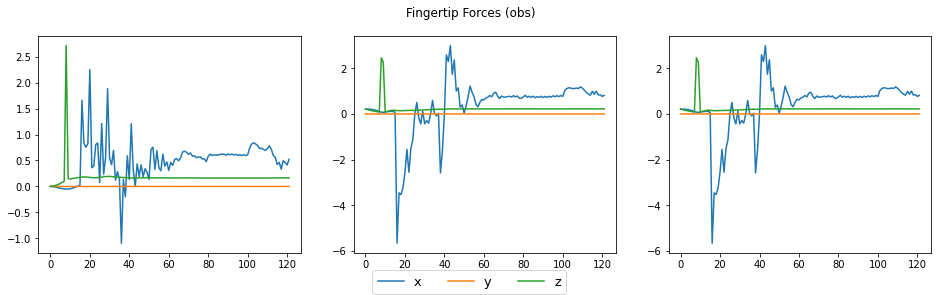

In [31]:
plot_obs_forces(ft_forces)

In [2]:
custom_params = get_custom_parameters(False, False)

parser = ArgumentParser()
for argument in custom_params:
    if ("name" in argument) and ("type" in argument or "action" in argument):
        help_str = ""
        if "help" in argument:
            help_str = argument["help"]

        if "type" in argument:
            if "default" in argument:
                parser.add_argument(argument["name"], type=argument["type"], default=argument["default"], help=help_str)
            else:
                parser.add_argument(argument["name"], type=argument["type"], help=help_str)
        elif "action" in argument:
            parser.add_argument(argument["name"], action=argument["action"], help=help_str)

    else:
        print()
        print("ERROR: command line argument name, type/action must be defined, argument not added to parser")
        print("supported keys: name, type, default, action, help")
        print()

parsed_args = parser.parse_args("")
agent_cfg_train = yaml.load(open('logs/trifinger/11-04-2021-11-41-47/agent_config.yaml', 'r'), Loader=yaml.SafeLoader)
task_cfg = yaml.load(open('logs/trifinger/11-04-2021-11-41-47/env_config.yaml', 'r'), Loader=yaml.SafeLoader)
logdir = 'logs/trifinger-play'
os.makedirs(logdir, exist_ok=True)

In [3]:
runner = Runner(LeibnizAlgoObserver())

In [4]:
runner.load(agent_cfg_train)

Found checkpoint
nn/weights.pth
Adding Central Value Network


In [5]:
player = runner.create_player()
player.restore(runner.load_path)

Running using python GPU...
[INFO] [2021.11.04::13-57-07]: [env_base]: Observations: 41
    robot_q: 9
    robot_u: 9
    object_q: 7
    object_q_des: 7
    command: 9
[INFO] [2021.11.04::13-57-07]: [env_base]: States: 113
    robot_q: 9
    robot_u: 9
    object_q: 7
    object_q_des: 7
    command: 9
    object_u: 6
    fingertip_state: 39
    robot_a: 9
    fingertip_wrench: 18
[INFO] [2021.11.04::13-57-07]: [env_base]: Action: 9
    command: 9
--------------------
[INFO] [2021.11.04::13-57-08]: [env_base]: Simulation physics parameters: 
<isaacgym._bindings.linux-x86_64.gym_38.SimParams object at 0x7fa991c21b30>
Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
[INFO] [2021.11.04::13-57-13]: [trifinger_env]: Trifinger Robot Asset: 
	 Number of bodies: 17
	 Number of shapes: 15
	 Number of dofs: 9
	 Number of actuated dofs: 9
[INFO] [2021.11.04::13-57-13]: [trifinger_env]: Trifinger Stage Asset: 
	 Number of bodies: 1
	 Numb

/scr1/.pyenv/versions/rlgpu/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [6]:
def play():
    n_games = player.games_num
    render = player.render_env
    n_game_life = player.n_game_life
    is_determenistic = player.is_determenistic
    sum_rewards = 0
    sum_steps = 0
    sum_game_res = 0
    n_games = n_games * n_game_life
    games_played = 0
    has_masks = False
    has_masks_func = getattr(player.env, "has_action_mask", None) is not None

    op_agent = getattr(player.env, "create_agent", None)
    if op_agent:
        agent_inited = True
        #print('setting agent weights for playerplay')
        # player.env.create_agent(player.env.config)
        # player.env.set_weights(range(8),player.get_weights())

    if has_masks_func:
        has_masks = player.env.has_action_mask()

    need_init_rnn = player.is_rnn
    traj_forces = []
    for _ in range(1):
        if games_played >= n_games:
            break

        obses = player.env_reset(player.env)
        batch_size = 1
        batch_size = player.get_batch_size(obses, batch_size)

        if need_init_rnn:
            player.init_rnn()
            need_init_rnn = False

        cr = torch.zeros(batch_size, dtype=torch.float32)
        steps = torch.zeros(batch_size, dtype=torch.float32)

        print_game_res = False

        for n in range(750):
            if has_masks:
                masks = player.env.get_action_mask()
                action = player.get_masked_action(
                    obses, masks, is_determenistic)
            else:
                action = player.get_action(obses, is_determenistic)
            obses, r, done, info = player.env_step(player.env, action)
            force_sensor = []
            for i in range(3):
                for dim in ['x', 'y','z']:
                    force_sensor.append(info[f'env/ft{i}_forces_{dim}'].cpu().numpy().item())
            traj_forces.append(force_sensor)

            cr += r
            steps += 1

            if render:
                player.env.render(mode='human')
                time.sleep(player.render_sleep)

            all_done_indices = done.nonzero(as_tuple=False)
            done_indices = all_done_indices[::player.num_agents]
            done_count = len(done_indices)
            games_played += done_count

            if games_played > 0:
                return traj_forces
                if player.is_rnn:
                    for s in player.states:
                        s[:, all_done_indices, :] = s[:,
                                                      all_done_indices, :] * 0.0

                cur_rewards = cr[done_indices].sum().item()
                cur_steps = steps[done_indices].sum().item()

                cr = cr * (1.0 - done.float())
                steps = steps * (1.0 - done.float())
                sum_rewards += cur_rewards
                sum_steps += cur_steps

                game_res = 0.0
                if isinstance(info, dict):
                    if 'battle_won' in info:
                        print_game_res = True
                        game_res = info.get('battle_won', 0.5)
                    if 'scores' in info:
                        print_game_res = True
                        game_res = info.get('scores', 0.5)
                if player.print_stats:
                    if print_game_res:
                        print('reward:', cur_rewards/done_count,
                              'steps:', cur_steps/done_count, 'w:', game_res)
                    else:
                        print('reward:', cur_rewards/done_count,
                              'steps:', cur_steps/done_count)

                sum_game_res += game_res
                if batch_size//player.num_agents == 1 or games_played >= n_games:
                    break

    return traj_forces

In [7]:
play()

[[0.0011575117241591215,
  0.21578621864318848,
  -0.21428455412387848,
  -2.7175790506817066e-09,
  1.1599340932200164e-10,
  1.1680727218799092e-10,
  0.0025175963528454304,
  0.21157078444957733,
  -0.2184360921382904],
 [-0.00163232849445194,
  0.21341754496097565,
  -0.2166406512260437,
  -4.24288337796952e-09,
  2.6515816209382592e-09,
  2.6121618201813135e-09,
  0.005958329886198044,
  0.19017811119556427,
  -0.23723337054252625],
 [-0.007625578437000513,
  0.20844320952892303,
  -0.22130565345287323,
  -8.008003149484466e-09,
  4.9210244768005396e-09,
  4.6352730542764675e-09,
  0.01169075071811676,
  0.16426312923431396,
  -0.2556634247303009],
 [-0.016004009172320366,
  0.1998891681432724,
  -0.2286287546157837,
  -1.286871320616001e-08,
  6.819692366377694e-09,
  5.962399463044221e-09,
  0.02427522838115692,
  0.1458863615989685,
  -0.26572680473327637],
 [-0.025619488209486008,
  0.18610884249210358,
  -0.23914434015750885,
  -1.9819283991751036e-08,
  7.590672979063129e-09

In [8]:
ft_forces = Out[7]

In [10]:
forces = np.array([np.array(x) for x in ft_forces[:150]])